## Machine Learning with PySpark

**Course Structure:**
* Chapter 1. Introduction
* Chapter 2. Classification
* Chapter 3. Regression
* Chapter 4. Ensembles and Pipelines

### CHAPTER 1. Introduction

#### Part 1.1 Machine learning & Spark

* We will learn how to build **Machine Learning models** on *large data sets* using **distributed computing techniques**
* Performance of models depend on data, in general, more data is better
* If the data is too big, it cannot fit into RAM, it has to page between RAM and disk, which is slow
* We can distribute the data across multiple computers in a cluster   

**Spark:**
* Spark is a general purpose framework for cluster computing
* Popular for two reasons:
    1. Faster than other Big Data technologies because it does processing in memory
    2. Developer-friendly interface with well-documented high-level API
* It consists of one or more **nodes** and a cluster manager
* The manager allocates resource and coordinates activities across the cluster
* The driver program communicates with the manager

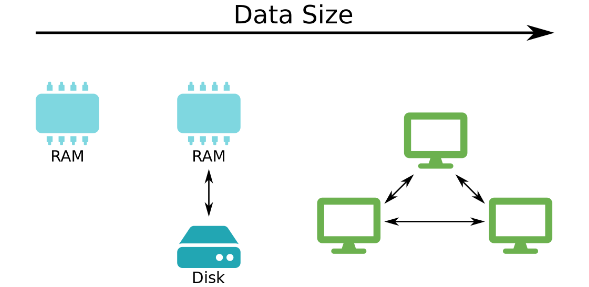

In [1]:
# display Spark approach for big data set
from IPython import display

display.Image("Images/22_spark.png")

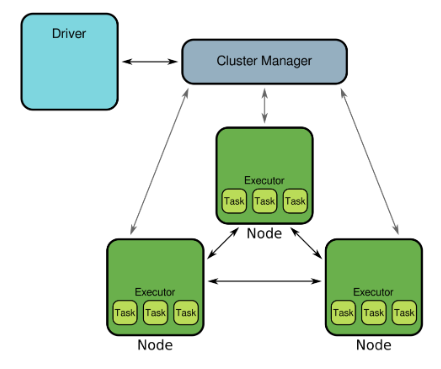

In [2]:
from IPython import display

display.Image("Images/22_spark_components.png")

#### Part 1.2 Connecting to Spark

* The connection with Spark is established by the **driver**, which can be written in Java, Scala, Python or R
* In Python, we use *'pyspark'* module
* Check version: *'pyspark.__version__'*
* *'pyspark'* has a few submodules to implement different aspects of Spark interface:
    * Structured Data: *'pyspark.sql'*
    * Streaming Data: *'pyspark.streaming'*
    * Machine Learning: *'pyspark.ml'*
* Tell the Spark where the cluster is located by providing a **Spark URL**, which can be remote or local
    * Remote Example: *'spark://<IP address | DNS name>:<port>'*
    * Local Example: *'local'* or *'local[4]'*
* Start by creating a SparkSession
    * Example: *'spark = SparkSession.builder.master('locao[*]').appName('first_spark_application).getOrCreate()'*
* Close connection to Spark after the work
    * Example: *'spark.stop()'*    

In [3]:
# Code for part 1.2

# creating a SparkSession
from pyspark.sql import SparkSession

# create SparkSession object
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

# version of Spark
print(spark.version)

# terminate the cluster
spark.stop()

3.5.0


#### Part 1.3 Loading data

* Spark represents tabular data using *'DataFrame'* class
* Its selected methods and attributes:
    * *'.count()'* gives the number of rows
    * *'.show()'* displays a subset of rows
    * *'.printSchema()'* gives views on column types
    * *'dtypes'* gives views on column types
* *'csv'* is a common format to store tabular data
* Use *'spark.read.csv()'* to read data from CSV file and returns a DataFrame
    * *'header'*: is the first row a header?
    * *'sep'*: field separator
    * *'schema'*: explicit column data types
    * *'inferSchema'*: deduce column data types from data?
    * *'nullValue'*: placeholder for missing data, it is case-sensitive
* You can specify the column types manually to avoid wrong column types

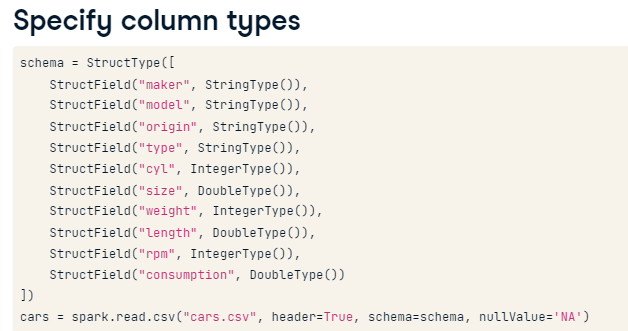

In [4]:
# display specify column types

from IPython import display
display.Image("Images/22_specify_column_type.png")

In [5]:
# Code for part 1.3

# loading flights data
from pyspark.sql import SparkSession

# create spark session: spark
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

# read data from CSV file
flights = spark.read.csv('22_datasets/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# get number of records
print("The data contain %d records." % flights.count())

# view the first five records
flights.show(5)

# check column data types
print(flights.dtypes)

The data contain 50000 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| NULL|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| NULL|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


In [6]:
# Code for part 1.3 (continue)

# loading SMS spam data
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# load data from a delimited file
sms = spark.read.csv('22_datasets/sms.csv', sep=';', header=False, schema=schema)
sms.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)


### CHAPTER 2. Classification

#### Part 2.1 Data Preparation

* Ways to prepare data for building a Machine Learning model:
    * Dropping column: *'df.drop()'* 
    * Selecting column: *'df.select()'*
    * Filtering out missing values: *'df.filter('cyl IS NULL').count()'*
    * Drop missing values: *'df.dropna()'*
    * Creating new columns: *'df.withColumn('newCol', operation)'*
    * Indexing categorical columns: *'StringIndexer(inputCol, outputCol).fit(df).transform(df)'*
    * Assembling columns: *'VectorAssembler(inpotCols, outputCol)'*

In [7]:
# Code for part 2.1

# removing columns and rows

# remove the 'flight' column
flights_drop_column = flights.drop('flight')

# number of records with missing 'delay' values
flights_drop_column.filter('delay IS NULL').count()

# remove records with missing 'delay' values
flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# remove records with missing values in any column and get the number of remaining rows
flights_none_missing = flights_valid_delay.dropna()
print(flights_none_missing.count())

47022


In [8]:
# Code for part 2.1 (continue)

# column manipulation
from pyspark.sql.functions import round

# convert 'mile' to 'km' and drop 'mile' column
flights = flights_none_missing
flights_km = flights.withColumn('km', round(flights.mile * 1.60934, 0)).drop('mile')

# create 'label' column indicating whether flights delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights.delay >= 15).cast('integer'))
flights_km.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+


In [9]:
# Code for part 2.1 (continue)

# categorical columns
from pyspark.ml.feature import StringIndexer

# create an indexer
flights = flights_km
indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')

# indexer identifies categories in the data
indexer_model = indexer.fit(flights)

# indexer creates a new column with numeric index values
flights_indexed = indexer_model.transform(flights)

# repeat the same process for other categorical columns
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)


+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|        0.0|    0.0|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|        0.0|    1.0|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|        1.0|    0.0|
|  5|  2|  1|     UA|SFO|  7.98|     102|    2| 885.0|    0|        0.0|    1.0|
|  7|  2|  6|     AA|ORD| 10.83|     135|   54|1180.0|    1|        1.0|    0.0|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+


In [10]:
# Code for part 2.1 (continue)

# assembling columns
from pyspark.ml.feature import VectorAssembler

# create an assembler object
flights = flights_indexed
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow', 'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')

# consolidate predictor columns
flights_assembled = assembler.transform(flights)

# check the column
flights_assembled.select('features', 'delay').show(5)

+--------------------+-----+
|            features|delay|
+--------------------+-----+
|[0.0,22.0,2.0,0.0...|   30|
|[2.0,20.0,4.0,0.0...|   -8|
|[9.0,13.0,1.0,1.0...|   -5|
|[5.0,2.0,1.0,0.0,...|    2|
|[7.0,2.0,6.0,1.0,...|   54|
+--------------------+-----+


#### Part 2.2 Decision Tree

* It is constructed using an algorithm called "Recursive Partitioning"
* Each node can be split with the most informative predictor
* This process repeats until certain criteria are met
* Building Decision Tree model:
    1. Train/Test split is essential for building machine learning models with *'.randomSplit()'* method
    2. Create a Decision Tree Classifier with *'DecisionTreeClassifier()'* method
    3. Learn from training data with *'.fit()'* method
    4. Make predictions on testing data with *'.transform()'* method, which adds new columns to the dataframe to display prediction and probability of predictions
    5. A confusion matrix can be used to describe the performance of a model on testing data, which has four values: true positive (TP), true negative (TN), false positive (FP), and false negative (FN)
    

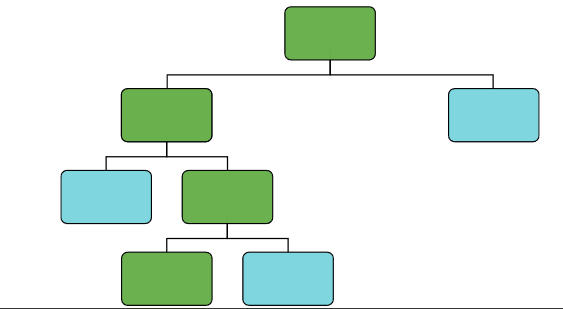

In [11]:
# display a decision tree model

from IPython import display
display.Image("Images/22_decision_tree.png")



In [12]:
# Code for part 2.2

# train/test split

# split into training and testing sets in a 80:20 ratio
flights = flights_assembled
flights_train, flights_test = flights.randomSplit([.8, .2], seed=43)

# check that training set has around 80% of records
training_ratio = flights_train.count() / flights.count()
print(training_ratio)


0.8025392369529156


In [13]:
# Code for part 2.2 (continue)

# build a Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier

# create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)

# create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)


+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1    |0.0       |[0.5277008310249307,0.47229916897506924]|
|1    |0.0       |[0.5277008310249307,0.47229916897506924]|
|0    |1.0       |[0.357074478269194,0.6429255217308061]  |
|1    |1.0       |[0.357074478269194,0.6429255217308061]  |
|1    |1.0       |[0.357074478269194,0.6429255217308061]  |
+-----+----------+----------------------------------------+


In [14]:
# Code for part 2.2 (continue)

# evaluate the Decision Tree

# create a confusion matrix
cm = prediction.groupBy('label', 'prediction').count()
cm.show()

# calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1176|
|    0|       0.0| 2332|
|    1|       1.0| 3587|
|    0|       1.0| 2190|
+-----+----------+-----+
0.6374798061389337


#### Part 2.3 Logistic Regression

* It uses a logistic function to model a binary target
* The value of y-axis is between 0 and 1
* The value above the threshold is considered TRUE, below is FALSE
* Use *'MultiClassificationEvaluator'* to evaluate with different metrics
* ROC curve plots the True Positive rate VS. False Positive rate when the threshold changes from 0 to 1
* AUC summarizes the ROC into a single number, the area under the curve

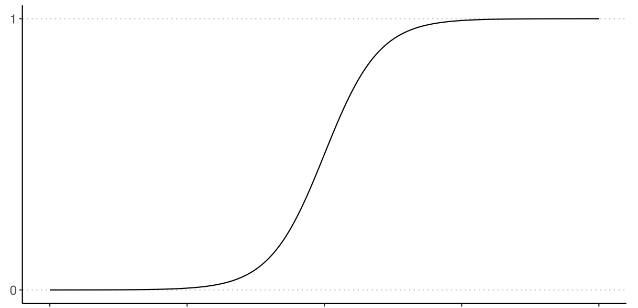

In [15]:
# display logistic regression curve
from IPython import display

display.Image("Images/22_logistic_curve.png")

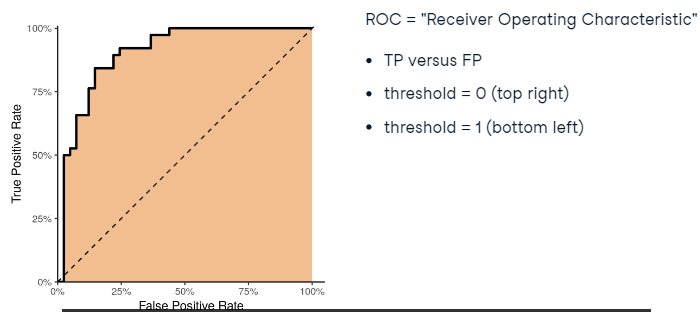

In [16]:
# display ROC curve
from IPython import display

display.Image("Images/22_roc_curve.png")

In [17]:
# Code for part 2.3 

# build a Logistic Regression model
from pyspark.ml.classification import LogisticRegression

# create a classifier object and train on the training data
logistic = LogisticRegression().fit(flights_train)

# create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1705|
|    0|       0.0| 2561|
|    1|       1.0| 3058|
|    0|       1.0| 1961|
+-----+----------+-----+


In [18]:
# Code for part 2.3 (continue)

# evaluate a Logistic Regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# calculate precision and recall
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()
precision = TP/ (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall = {:.2f}'.format(precision, recall))

# find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})


# find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName:"areaUnderROC"})
print('weighted precision = {:.2f}\nAUC = {:.2f}'.format(weighted_precision, auc))

precision = 0.61
recall = 0.64
weighted precision = 0.60
AUC = 0.64


#### Part 2.4 Turning text into tables

* Text data preparation is challenging, we need to turn them into tables
* Starting with a collection of documents, each document will become a record in the table
* The text in each document will be mapped to columns in the table
    1. Remove punctuation with regular expression
       * *'from pyspark.sql.functions import regexp_replace'*
    2. Tokenize the document into words or tokens
       * *'from pyspark.ml.feature import Tokenizer'*
    3. Remove stop words or common words that do not carry too much information 
       * *'from pyspark.ml.feature import StopWordsRemover'*
    4. Then we get a table called "term-document matrix"
    5. Use feature hashing to convert the words into numbers
       * *'from pyspark.ml.feature import HashingTF'*
    6. Convert the result into TF-IDF
       * *'from pyspark.ml.feature import IDF'*

In [19]:
# Code for part 2.4

# punctuation, numbers and tokens
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer

# get SMS data
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])
sms = spark.read.csv('22_datasets/sms.csv', header=False, sep=';', schema=schema)
sms.show(5)

# remove punctuation
wrangled = sms.withColumn('text', regexp_replace(sms.text, '[_():;,.!?\\-]', ' '))
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, '[0-9]', ' '))

# merge multiple spaces
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, ' +', ' '))

# split the text into words
wrangled = Tokenizer(inputCol='text', outputCol='words').transform(wrangled)
wrangled.show(4, truncate=False)

+---+--------------------+-----+
| id|                text|label|
+---+--------------------+-----+
|  1|Sorry, I'll call ...|    0|
|  2|Dont worry. I gue...|    0|
|  3|Call FREEPHONE 08...|    1|
|  4|Win a 1000 cash p...|    1|
|  5|Go until jurong p...|    0|
+---+--------------------+-----+
+---+----------------------------------+-----+------------------------------------------+
|id |text                              |label|words                                     |
+---+----------------------------------+-----+------------------------------------------+
|1  |Sorry I'll call later in meeting  |0    |[sorry, i'll, call, later, in, meeting]   |
|2  |Dont worry I guess he's busy      |0    |[dont, worry, i, guess, he's, busy]       |
|3  |Call FREEPHONE now                |1    |[call, freephone, now]                    |
|4  |Win a cash prize or a prize worth |1    |[win, a, cash, prize, or, a, prize, worth]|
+---+----------------------------------+-----+---------------------------

In [20]:
# Code for part 2.4 (continue)

# stop words and hashing
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

# get an updated version of sms
sms = wrangled
# remove stop words
wrangled = StopWordsRemover(inputCol='words', outputCol='terms').transform(sms)

# apply the hashing trick
wrangled = HashingTF(inputCol='terms', outputCol='hash', numFeatures=1024).transform(wrangled)

# convert hashed symbols to TF-IDF
tf_idf = IDF(inputCol='hash', outputCol='features').fit(wrangled).transform(wrangled)
tf_idf.select('terms', 'features').show(4, truncate=False)

+--------------------------------+----------------------------------------------------------------------------------------------------+
|terms                           |features                                                                                            |
+--------------------------------+----------------------------------------------------------------------------------------------------+
|[sorry, call, later, meeting]   |(1024,[138,384,577,996],[2.273418200008753,3.6288353225642043,3.5890949939146903,4.104259019279279])|
|[dont, worry, guess, busy]      |(1024,[215,233,276,329],[3.9913186080986836,3.3790235241678332,4.734227298217693,4.58299632849377]) |
|[call, freephone]               |(1024,[133,138],[5.367951058306837,2.273418200008753])                                              |
|[win, cash, prize, prize, worth]|(1024,[31,47,62,389],[3.6632029660684124,4.754846585420428,4.072170704727778,7.064594791043114])    |
+--------------------------------+--------------

In [21]:
# Code for part 2.4 (continue)

# training a spam classifier
from pyspark.ml.classification import LogisticRegression

# split data into training and testing sets
sms = tf_idf
sms_train, sms_test = sms.randomSplit([.8, .2], seed=13)

# fit a Logistic Regression model to the training data
logistic = LogisticRegression(regParam=0.2).fit(sms_train)

# make predictions on the testing data
prediction = logistic.transform(sms_test)

# create a confusion matrix, comparing prediction to known labels
prediction.groupBy('label', 'prediction').count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   41|
|    0|       0.0|  948|
|    1|       1.0|  105|
|    0|       1.0|    2|
+-----+----------+-----+


### CHAPTER 3. Regression

#### Part 3.1 One-Hot Encoding

* For regression model, converting categorical columns to indexed numerical values is not sufficient
* The numbers in indexed numerica values **DO NOT have any meanings**
* We need to convert the index values into a format which we can perform meaningful mathematical operations
* We need to create a column for each of the levels: *'dummy variables'*
* The levels are mutually exclusive, so we can drop one of them
* This process is called **One-Hot Encoding**
* Use *'from pyspark.ml.feature import OneHotEncoder'* to achieve that

In [22]:
# Code for part 3.1

# encoding flight origin

from pyspark.ml.feature import OneHotEncoder

# create an instance of the one-hot encoder
flights = flights_assembled
# flights.show(5)
onehot = OneHotEncoder(inputCols=['org_idx'], outputCols=['org_dummy'])

# apply the one hot encoder to the flights data
onehot = onehot.fit(flights)
flights_onehot = onehot.transform(flights)

# check the results
flights_onehot.select('org', 'org_idx', 'org_dummy').distinct().sort('org_idx').show()


+---+-------+-------------+
|org|org_idx|    org_dummy|
+---+-------+-------------+
|ORD|    0.0|(7,[0],[1.0])|
|SFO|    1.0|(7,[1],[1.0])|
|JFK|    2.0|(7,[2],[1.0])|
|LGA|    3.0|(7,[3],[1.0])|
|SMF|    4.0|(7,[4],[1.0])|
|SJC|    5.0|(7,[5],[1.0])|
|TUS|    6.0|(7,[6],[1.0])|
|OGG|    7.0|    (7,[],[])|
+---+-------+-------------+


#### Part 3.2 Regression

* Find the model that best describes the linear relationship between variables
* The **residual** is the difference between the observed value and the corresponding modeled value
* We want to find a model that **minimizes the residual**
* Most common loss function: 
    * Mean Sqaured Error (MSE)
    * Mean Absolute Error (MAE) 
    * R^2 (r2)

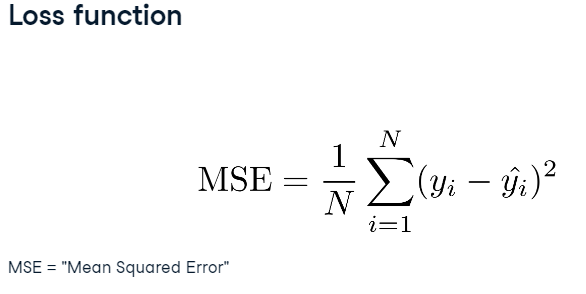

In [23]:
# display regression loss function

from IPython import display

display.Image("Images/22_regression_loss_function.png")

In [24]:
# Code for part 3.2 

# flight duration model: just distance
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# get the column needed and convert to features
flights = flights_onehot
flights = flights.drop('features')
assembler = VectorAssembler(inputCols=['km'], outputCol='features')

# consolidate predictor columns
flights_assembled = assembler.transform(flights)
# flights_assembled.show(5)

# split into training and testing sets
flights_train, flights_test = flights_assembled.randomSplit([.8, .2], seed=43)

# create a regression object and train on training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# create predictions for the testing data and take a look at the predictions
predictions = regression.transform(flights_test)
predictions.select('duration', 'prediction').show(5, False)

# calculate the RMSE
RegressionEvaluator(labelCol='duration', metricName="rmse").evaluate(predictions)


+--------+------------------+
|duration|prediction        |
+--------+------------------+
|230     |238.34694153276467|
|250     |213.0406169037472 |
|170     |133.34457963922952|
|251     |245.0701143446529 |
|155     |141.72966033720246|
+--------+------------------+


16.985146657611153

In [25]:
# Code for part 3.2 (continue)

# interpreting the coefficients

# inter
inter = regression.intercept
print(inter)

# coefficients
coefs = regression.coefficients
print(coefs)

# average minutes per km
minutes_per_km = regression.coefficients[0]
print(minutes_per_km)

# average speed in km per hour
avg_speed = 1 * 60 / minutes_per_km
print(avg_speed)

44.205883931048604
[0.07554126754930586]
0.07554126754930586
794.2678478467143


In [26]:
# Code for part 3.2 (continue)

# flight duration model: adding origin airport
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# get the column needed and convert to features
flights = flights_onehot
flights = flights.drop('features')
assembler = VectorAssembler(inputCols=['km', 'org_dummy'], outputCol='features')

# consolidate predictor columns
flights_assembled = assembler.transform(flights)
# flights_assembled.show(5)

# split data into training and testing sets
flights_train, flights_test = flights_assembled.randomSplit([.8, .2], seed=43)

# create a regression object and train on training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# create predictions for the testing data and take a look at the predictions
predictions = regression.transform(flights_test)
# predictions.select('duration', 'prediction').show(5, False)

# calculate the RMSE
RegressionEvaluator(labelCol='duration', metricName="rmse").evaluate(predictions)
# note the RMSE is smaller than before!

11.137472137532653

In [27]:
# Code for part 3.2 (continue)

# intercepting coefficients

# average speed in km per hour
avg_per_hour = 1 * 60 / regression.coefficients[0]
print(avg_per_hour)

# average minutes on ground at OGG (OGG is the reference level)
inter = regression.intercept
print(inter)

# average minutes on ground at JFK
avg_ground_jfk = inter + regression.coefficients[3]
print(avg_ground_jfk)

# avarage minutes on ground at LGA
avg_ground_lga = inter + regression.coefficients[4]
print(avg_ground_lga)

808.2612708599396
15.357092930587914
68.25396484371434
62.585555138000785


#### Part 3.3 Buckeing & Engineering

* Model performance is relied on carefully manipulated features, two approaches to doing this:
1. Bucketing:
    * Converting continuous values into discrete values by assigning them to buckets/bins
    * The resulting variable is often a more powerful predictor than the original one 
    * This requires you to have a well-designed bucket boundaries  
    * Use *'pyspark.ml.feature import Bucketizer'*
    * After bucketing, you need to **one-hot encode** these indexed values
2. Feature Engineering:
    * Operations on a single column:
        1. *'log()'*
        2. *'sqrt()'*
        3. *'pow()'*
    * Operations on two columns:
        1. product
        2. ratio
      

In [28]:
# Code for part 3.3

# bucketing departure time
from pyspark.ml.feature import Bucketizer, OneHotEncoder

# crate buckets at 3-hour intervals through the day
buckets = Bucketizer(splits=[0, 3, 6, 9, 12, 15, 18, 21, 24], inputCol='depart', outputCol='depart_bucket')

# bucket the departure time
flights = flights_onehot
bucketed = buckets.transform(flights)
bucketed.select('depart', 'depart_bucket').show(5)

# create a one-hot encoder
onehot = OneHotEncoder(inputCols=['depart_bucket'], outputCols=['depart_dummy'])

# one-hot encode the bucketed departure times
flights_onehot_bucket = onehot.fit(bucketed).transform(bucketed)
flights_onehot_bucket.select('depart', 'depart_bucket', 'depart_dummy').show(5)

+------+-------------+
|depart|depart_bucket|
+------+-------------+
| 16.33|          5.0|
|  6.17|          2.0|
| 10.33|          3.0|
|  7.98|          2.0|
| 10.83|          3.0|
+------+-------------+
+------+-------------+-------------+
|depart|depart_bucket| depart_dummy|
+------+-------------+-------------+
| 16.33|          5.0|(7,[5],[1.0])|
|  6.17|          2.0|(7,[2],[1.0])|
| 10.33|          3.0|(7,[3],[1.0])|
|  7.98|          2.0|(7,[2],[1.0])|
| 10.83|          3.0|(7,[3],[1.0])|
+------+-------------+-------------+


In [29]:
# Code for part 3.3 (continue)

# flight duration model: adding departure time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# get the column needed and convert to features
flights = flights_onehot_bucket
flights = flights.drop('features')
assembler = VectorAssembler(inputCols=['km', 'org_dummy', 'depart_dummy'], outputCol='features')

# consolidate predictor columns
flights_assembled = assembler.transform(flights)
# flights_assembled.show(5)

# split data into training and testing sets
flights_train, flights_test = flights_assembled.randomSplit([.8, .2], seed=43)

# create a regression object and train on training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# create predictions for the testing data and take a look at the predictions
predictions = regression.transform(flights_test)

# find the RMSE on testing data
rmse = RegressionEvaluator(labelCol='duration', metricName="rmse").evaluate(predictions)
print("The test RMSE is", rmse)

# avarage minutes on ground at OGG for flights departing between 21:00 and 24:00
avg_eve_ogg = regression.intercept
print(avg_eve_ogg)

# average minutes on ground at OGG for flights departing between 00:00 and 03:00
avg_night_ogg = regression.intercept + regression.coefficients[8]
print(avg_night_ogg)

# avarage minutes on ground at JFK for flights departing between 03:00 and 06:00
avg_night_jfk = regression.intercept + regression.coefficients[3] + regression.coefficients[9]
print(avg_night_jfk)

The test RMSE is 10.829276105227043
10.010219268195828
-3.4258550175361933
62.34096324377394


#### Part 3.4 Regularization

* Regularization helps you to select only the most useful features
* It is useful when you have too many features
* It adds additional "regularization" or "shrinkage" term to the loss function 
* The **regularization term** can be either
    * **Lasso** -> absolute value of the coefficients
    * **Ridge** -> square of the coefficients
* It penalizes when you have too many coefficients
* It is possible to have a blend of Lasso and Ridge regression
* Strength of regularization determined by parameter $\lambda$:
    * $\lambda = 0$ -> no regularization (standard regression)
    * $\lambda = \infty$ -> complete regularization (all coefficients zero) 

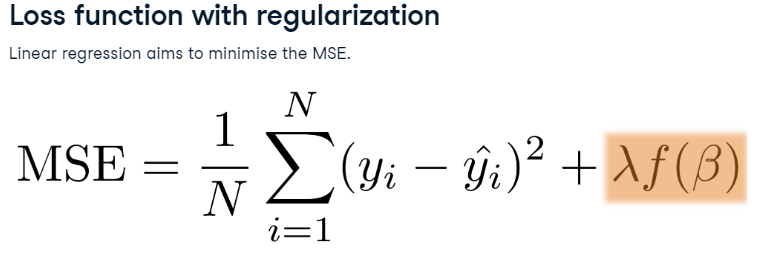

In [30]:
# display new loss function

from IPython import display

display.Image("Images/22_new_loss_function.png")

In [31]:
# preparation before code for part 3.4

# convert column 'dow' and 'mon' to one-hot encoded columns
from pyspark.ml.feature import OneHotEncoder

# 'mon' to 'mon_dummy'
flights = flights_onehot_bucket
onehot = OneHotEncoder(inputCols=['mon'], outputCols=['mon_dummy'])
flights_onehot_bucket = onehot.fit(flights).transform(flights)

# 'dow' to 'dow_dummy'
flights = flights_onehot_bucket
onehot = OneHotEncoder(inputCols=['dow'], outputCols=['dow_dummy'])
flights_onehot_bucket = onehot.fit(flights).transform(flights) 

flights_onehot_bucket.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+--------------------+-------------+-------------+-------------+--------------+-------------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|            features|    org_dummy|depart_bucket| depart_dummy|     mon_dummy|    dow_dummy|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+--------------------+-------------+-------------+-------------+--------------+-------------+
|  0| 22|  2|     UA|ORD| 16.33|      82|   30| 509.0|    1|        0.0|    0.0|[0.0,22.0,2.0,0.0...|(7,[0],[1.0])|          5.0|(7,[5],[1.0])|(11,[0],[1.0])|(6,[2],[1.0])|
|  2| 20|  4|     UA|SFO|  6.17|      82|   -8| 542.0|    0|        0.0|    1.0|[2.0,20.0,4.0,0.0...|(7,[1],[1.0])|          2.0|(7,[2],[1.0])|(11,[2],[1.0])|(6,[4],[1.0])|
|  9| 13|  1|     AA|ORD| 10.33|     195|   -5|1989.0|    0|        1.0|    0.0|[9.0,13.0,1.0,1.0...|(7,[0],[1.0])|          3.0|(7,[3]

In [32]:
# Code for part 3.4

# flight duration model: more features!
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# get the column needed and convert to features
flights = flights_onehot_bucket
flights = flights.drop('features')
assembler = VectorAssembler(inputCols=['km', 'org_dummy', 'depart_dummy', 'dow_dummy', 'mon_dummy'], outputCol='features')

# consolidate predictor columns
flights_assembled = assembler.transform(flights)
# flights_assembled.show(5)

# split data into training and testing sets
flights_train, flights_test = flights_assembled.randomSplit([.8, .2], seed=43)

# fit the linear regression model to the training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# make predictions on testing data
predictions = regression.transform(flights_test)

# calculate RMSE on testing data
rmse = RegressionEvaluator(labelCol='duration', metricName='rmse').evaluate(predictions)
print("The test RMSE is", rmse)

# look at the model coefficients
coeffs = regression.coefficients
print(coeffs)

# we have too many non-zero coefficients!


The test RMSE is 10.720367622596383
[0.0743363738942103,27.766651628325917,20.544354028225282,52.015248261737575,46.189560083168374,15.451827928821599,17.880315657729305,17.838825062777403,-13.89681582702079,0.36938279538776975,4.0896921099853385,6.982590813025684,4.682919884651455,8.861664422592668,8.700708677611553,0.67755907865209,0.47694836609917735,0.004801983315355316,0.426896965941456,0.42399927042521246,0.3384201062828632,-1.9739041514807802,-2.414169946607348,-2.0382260272894683,-3.5805902155782925,-4.293398646233518,-4.174989971727158,-4.302538675628994,-4.268265121076613,-3.9059660813952024,-2.646993589121753,-0.7747270277769657]


In [33]:
# flight duration model: regularization!
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# fit the lasso model (lambda=1, alpha=1) to training data
regression = LinearRegression(labelCol='duration', regParam=1, elasticNetParam=1).fit(flights_train)

# calculate the RMSE on testing data
predictions = regression.transform(flights_test)
rmse = RegressionEvaluator(labelCol='duration', metricName='rmse').evaluate(predictions)
print("The test RMSE is", rmse)

# look at the model coefficients
coeffs = regression.coefficients
print(coeffs)

# number of zero coefficients
zero_coeff = sum([beta == 0 for beta in regression.coefficients])
print('Number of coefficients equal to 0:', zero_coeff)

# see how numbers of coefficients decreased!

The test RMSE is 11.67566581046407
[0.07343488601059353,5.722429902489301,0.0,28.940710236598907,22.00911220473862,-2.2402020354984766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1229855796385186,1.06746022706495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Number of coefficients equal to 0: 25


### CHAPTER 4. Ensembles & Pipelines

#### Part 4.1 Pipeline

* Pipeline helps to streamline the workflow
* Pipeline also ensures that no leakage of information between training and testing data sets
* *'.fit()'* method only for training data
* *'.transform()'* method for both training and testing data
* A pipeline consists of a series of operations combined as a single unit
* Use *'from pyspark.ml import Pipeline'*

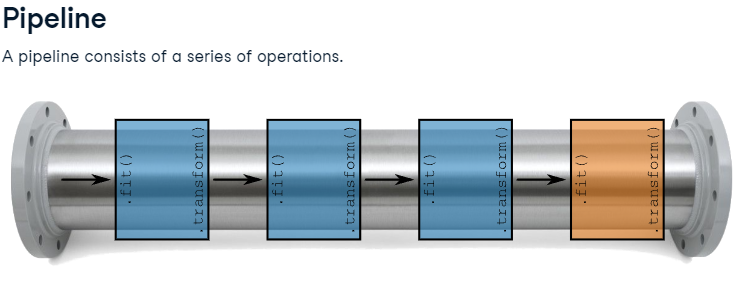

In [34]:
# display piepline

from IPython import display

display.Image("Images/22_pipeline.png")

In [35]:
# Code for part 4.1

# flight duration model: pipeline stages
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression

# convert categorical strings to index values
indexer = StringIndexer(inputCol='org', outputCol='org_idx')

# one-hot encode index values
onehot = OneHotEncoder(inputCols=['org_idx', 'dow'], outputCols=['org_dummy', 'dow_dummy'])

# assemble predictions into a single column
assembler = VectorAssembler(inputCols=['km', 'org_dummy', 'dow_dummy'], outputCol='features')

# a linear regression object
regression = LinearRegression(labelCol='duration')

In [36]:
# Code for part 4.1 (continue)

# flight duration model: pipeline model
from pyspark.ml import Pipeline

# get the original data
flights = spark.read.csv('22_datasets/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# convert 'mile' to 'km'
flights = flights.withColumn('km', round(flights.mile * 1.60934, 0)).drop('mile')

# split data into training and testing data
flights_train, flights_test = flights.randomSplit([.8, .2], seed=13)

# construct a pipeline
pipeline = Pipeline(stages=[indexer, onehot, assembler, regression])

# train the pipeline on the training data
pipeline = pipeline.fit(flights_train)

# make predictions on the testing data
predictions = pipeline.transform(flights_test)
predictions.select('duration', 'prediction').show(5)

+--------+------------------+
|duration|        prediction|
+--------+------------------+
|     385|377.34661750108603|
|     379|364.04381688061255|
|     130|131.59537849620068|
|     230| 259.0334410329645|
|      64| 71.99288633072742|
+--------+------------------+


In [37]:
# Code for part 4.1 (continue)

# SMS spam pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# break text into tokens at non-word characters
tokenizer = Tokenizer(inputCol='text', outputCol='words')

# remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='terms')

# apply the hashing trick and transform to IDF
hasher = HashingTF(inputCol='terms', outputCol='hash')
idf = IDF(inputCol='hash', outputCol='features')

# create a logistic regression object
logistic = LogisticRegression()

# get SMS spam data 
# specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# load data from a delimited file
sms = spark.read.csv('22_datasets/sms.csv', sep=';', header=False, schema=schema)

# split data into training and testing data sets
sms_train, sms_test = sms.randomSplit([.8, .2], seed=13)

# create a pipeline model
pipeline = Pipeline(stages=[tokenizer, remover, hasher, idf, logistic])

# train the pipeline model on the training data
pipeline = pipeline.fit(sms_train)

# make predictions on the testing data
predictions = pipeline.transform(sms_test)
predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
+-----+----------+


#### Part 4.2 Cross-Valiadation

* We are randomly splitting the data into training and testing sets
* We just get ONE estimate of the model performance
* It would be better if we could test the model multiple times
* We still split data into training and testing data
* We split training data more into several "partitions" or "folds"
* Each fold can be treated as testing data set in turn
* Use *'from pyspark.ml.tuning import CrossValidator, ParamGridBuilder'* to craete a cross-validation object

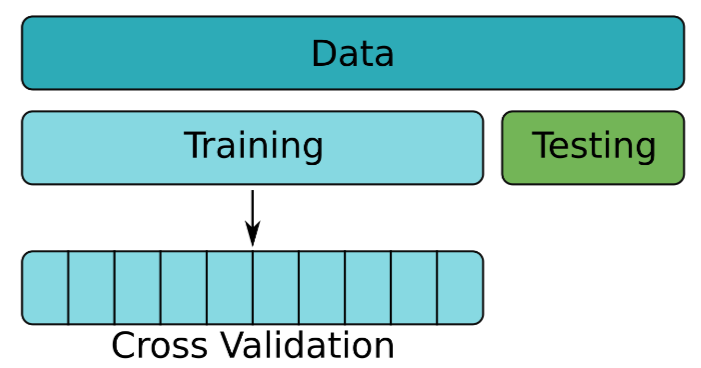

In [38]:
# display cross-validation

from IPython import display
display.Image("Images/22_cross_validation.png")

In [39]:
# Code for part 4.2

# cross-validating a simple flight duration model (km only)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# create an empty parameter grid
params = ParamGridBuilder().build()

# create objects for building and evaluating a regresion model
regression = LinearRegression(labelCol='duration')
evaluator = RegressionEvaluator(labelCol='duration')

# create a cross validator
cv = CrossValidator(estimator=regression,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=5)

# get the original data
flights = spark.read.csv('22_datasets/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# convert 'mile' to 'km'
flights = flights.withColumn('km', round(flights.mile * 1.60934, 0)).drop('mile')

# assemble to features
flights = VectorAssembler(inputCols=['km'], outputCol='features').transform(flights)

# split data into training and testing data
flights_train, flights_test = flights.randomSplit([.8, .2], seed=13)

# train and test model on multiple folds of the training data
cv = cv.fit(flights_train)

In [40]:
# Code for part 4.2 (continue)

# cross validating flight duration model pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# create an indexer for the org field
indexer = StringIndexer(inputCol='org', outputCol='org_idx')

# create a one-hot encoder for the indexed org field
onehot = OneHotEncoder(inputCols=['org_idx'], outputCols=['org_dummy'])

# assemble the km and one-hot encoded fields
assembler = VectorAssembler(inputCols=['km', 'org_dummy'], outputCol='features')

# create a regression object
regression = LinearRegression(labelCol='duration')

# create a pipeline and cross-validator 
pipeline = Pipeline(stages=[indexer, onehot, assembler, regression])
evaluator = RegressionEvaluator(labelCol='duration')
params = ParamGridBuilder().build()
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=params,
                    evaluator=evaluator)

#### Part 4.3 Grid Search

* So far we used default model hyperparameters for everything  
* The model performance could be better if we chose better model hyperparameters
* We build a selection of models through parameter grid, one for each set of model hyperparameters
* Evaluate the models and choose the best one
* It works well with cross-validation

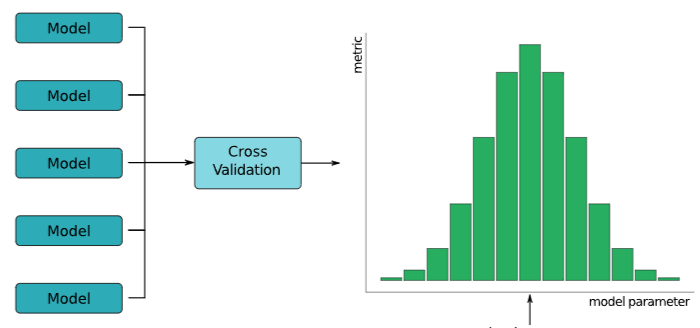

In [41]:
# display grid search

from IPython import display

display.Image("Images/22_grid_search.png")

In [42]:
# Code for part 4.3

# optimizing flights linear regression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# build a pipeline model with default parameters

# create an indexer for the org field
indexer = StringIndexer(inputCol='org', outputCol='org_idx')
# create a one-hot encoder for the indexed org field
onehot = OneHotEncoder(inputCols=['org_idx'], outputCols=['org_dummy'])
# assemble the km and one-hot encoded fields
assembler = VectorAssembler(inputCols=['km', 'org_dummy'], outputCol='features')
# create a regression object
regression = LinearRegression(labelCol='duration')
# create a pipeline and cross-validator 
pipeline = Pipeline(stages=[indexer, onehot, assembler, regression])
evaluator = RegressionEvaluator(labelCol='duration', metricName='rmse')

# create parameter grid
params = ParamGridBuilder()

# add grids for two parameters
params = params.addGrid(regression.regParam, [0.01, 0.1, 1.0, 1.0]).addGrid(regression.elasticNetParam, [0.0, 0.5, 1.0])

# build the parameter build
params = params.build()
print('Number of models to be tested: ', len(params))

# create cross-validator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=5)


Number of models to be tested:  12


In [43]:
# Code for part 4.3 (continue)

# dissecting the best flight duration model

# get the data
flights = spark.read.csv('22_datasets/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# convert 'mile' to 'km'
flights = flights.withColumn('km', round(flights.mile * 1.60934, 0)).drop('mile')

# split data into training and testing data
flights_train, flights_test = flights.randomSplit([.8, .2], seed=13)

# fit the model on the training data
cv = cv.fit(flights_train)

# get the best model from cross-validation
best_model = cv.bestModel

# look at the stagess in the best model
print(best_model.stages)

# get the parameters for the LinearRegression object in the best model
best_model.stages[3].extractParamMap()

# make predictions on testing data
predictions = best_model.transform(flights_test)
print("RMSE = ", evaluator.evaluate(predictions))

[StringIndexerModel: uid=StringIndexer_82ce34a22fdd, handleInvalid=error, OneHotEncoderModel: uid=OneHotEncoder_bd6ee69e7734, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1, VectorAssembler_f43bd17d7acf, LinearRegressionModel: uid=LinearRegression_b3ead2970017, numFeatures=8]
RMSE =  11.012865738560498


In [45]:
# Code for part 4.3 (continue)

# SMS spam optimized
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# prepare steps for the piepline
# break text into tokens at non-word characters
tokenizer = Tokenizer(inputCol='text', outputCol='words')
# remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='terms')
# apply the hashing trick and transform to IDF
hasher = HashingTF(inputCol='terms', outputCol='hash')
idf = IDF(inputCol='hash', outputCol='features')
# create logistic regression model
logistic = LogisticRegression()
# create evaluator
# evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

# prepare SMS spam data 
# specify column names and types
schema = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])

# load data from a delimited file
sms = spark.read.csv('22_datasets/sms.csv', sep=';', header=False, schema=schema)
# split data into training and testing data sets
sms_train, sms_test = sms.randomSplit([.8, .2], seed=13)

# create a pipeline model
pipeline = Pipeline(stages=[tokenizer, remover, hasher, idf, logistic])

# create parameter grid
params = ParamGridBuilder()

# add grid for hashing trick parameters
params = params.addGrid(hasher.numFeatures, [1024, 4096, 16384]).addGrid(hasher.binary, [True, False])

# add grid for logistic regression parameters
params = params.addGrid(logistic.regParam, [0.01, 0.1, 1.0, 10.0]).addGrid(logistic.elasticNetParam, [0.0, 0.5, 1.0])

# build parameter grid
params = params.build()

# create cross-validator based on the params
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=params,
                    evaluator = evaluator,
                    numFolds= 5)


#### Part 4.4 Ensemble

* Ensemble is **a collection of models**
* Models can be combined to form a "collection" or an "ensemble" which is more powerful than each of the individual models alone
* **Diversity** and **Independence** are important because the best collective decisions are product of disagreement and contest, not consensus or compromise
* Common ensemble methods:
    1. Random Forest: an ensemble of Decision Trees
        * Each tree is trained on a random subset of data (diversity)
        * A random subset of features is used for splitting at each node (diversity) 
        * No two trees in the forest should be the same (diversity)
        * All trees are operated in parallel (independence)
        * You can also get **feature importance** from Random Forest
        * Use *'from pyspark.ml.classification import RandomForestClassfier'*
    2. Gradient-Boosted Trees: iterative boosting algorithm
       * The trees work in series, rather than in parallel
       * Each tree learns from its previous tree by emphasizing training instances with incorrect predictions
       * Use *'from pyspark.ml.classification import GBTClassifier'*


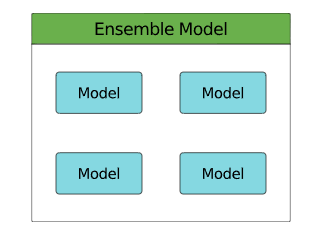

In [46]:
# display ensemble model

from IPython import display

display.Image("Images/22_ensemble_model.png")

In [54]:
# Code for part 4.4

# delayed flights with Gradient-Boosted Trees
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# prepare the data
flights = spark.read.csv('22_datasets/flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights = flights.filter('delay IS NOT NULL')
flights = flights.withColumn('label', (flights.delay >= 15).cast('integer'))
flights = flights.select('mon', 'depart', 'duration', 'label')
assembler = VectorAssembler(inputCols=['mon', 'depart', 'duration'], outputCol='features')
flights = assembler.transform(flights)
flights_train, flights_test = flights.randomSplit([.8, .2], seed=13)

# create model objects and train on training data
tree = DecisionTreeClassifier().fit(flights_train)
gbt = GBTClassifier().fit(flights_train)

# compare AUC on testing data
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
print(evaluator.evaluate(tree.transform(flights_test)))
print(evaluator.evaluate(gbt.transform(flights_test)))

# find the number of trees and the relative importance of features
print(gbt.getNumTrees)
print(gbt.featureImportances)

# note the AUC is higher in ensemble model!

0.6389205635178017
0.6744486117040775
20
(3,[0,1,2],[0.3390488063524824,0.3074354159910133,0.3535157776565043])


In [55]:
# Code for part 4.4 (continue)

# delayed flights with a Random Forest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# create a random forest classifier
forest = RandomForestClassifier()

# create a parameter grid
params = ParamGridBuilder().addGrid(forest.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2']).addGrid(forest.maxDepth, [2, 5, 10]).build()

# create a evaluator 
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

# create a cross-validator
cv = CrossValidator(estimator=forest,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=5)

cv_fit = cv.fit(flights_train)


In [56]:
# Code for part 4.4 (continue)

# evaluating random forest

# average AUC for each parameter combination in grid
print(cv_fit.avgMetrics)

# average AUC for the best model
print(max(cv_fit.avgMetrics))

# optimal parameter value for maxDepth, featureSubsetStrategy
print(cv_fit.bestModel.explainParam('maxDepth'))
print(cv_fit.bestModel.explainParam('featureSubsetStrategy'))

# AUC for best model on testing data
print(evaluator.evaluate(cv_fit.transform(flights_test)))

# the model performs great!

[0.6216467609279532, 0.6598198886341207, 0.6685468697323571, 0.6427441769920089, 0.6627789100622553, 0.6730515285673092, 0.6413346141817582, 0.6630164476858966, 0.6703745741540372, 0.6413346141817582, 0.6630164476858966, 0.6703745741540372]
0.6730515285673092
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30]. (default: 5, current: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (de

This is the end of this course!